# DS3010: Predicting the Consumer Price Index (CPI)
This jupyter notebook allows you to apply all the models we tried in one convenient location. This code is largely the same from the original notebooks, but contains extra annotations.

For each of the major models, we recommend restarting the jupyter notebook kernel before the import statements and running the model.

## Model 1: Random Forest


In [1]:
# necessary imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from prettytable import PrettyTable

In [2]:
# set up data
df = pd.read_csv('ALL_DATA_Marc93.csv') # read the data 
y = list(df['CPI']) # get the predictor result 
X = np.array(df[['SPY','DGS6MO','UNRATE','G17']]) # read the predictor variables 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) # train test split 

In [3]:
# contruct prettytable
table = PrettyTable() # for reading the results 
table.field_names = ['Max Depth', 'R-Squared(Train)', 'R-Squared(Test)' ,'MSE (Test)'] # headers
    
for depth in range(2,12): # testing different depths for accuracies 
    regr = RandomForestRegressor(max_depth=depth, random_state=0) # making the regression
    regr.fit(X_train, y_train) # training it 
    table.add_row([depth,regr.score(X_train,y_train),regr.score(X_test,y_test),mse(y_test, regr.predict(X_test))]) # appending results 

print(table)

+-----------+--------------------+--------------------+--------------------+
| Max Depth |  R-Squared(Train)  |  R-Squared(Test)   |     MSE (Test)     |
+-----------+--------------------+--------------------+--------------------+
|     2     | 0.8353813582436367 | 0.8425402588694594 | 213.80091294165456 |
|     3     | 0.9429146748456029 | 0.9537182021692734 | 62.84203541644976  |
|     4     | 0.9679514963005651 | 0.9730621762939294 | 36.57653225940792  |
|     5     | 0.9805769824381755 | 0.977673493565961  | 30.31522485762179  |
|     6     | 0.9888965538004568 | 0.9825484232078701 | 23.695981103738017 |
|     7     | 0.9921185610628718 | 0.9838653630551175 | 21.907822812550904 |
|     8     | 0.9932663975803971 | 0.9854344255433612 | 19.77732907465699  |
|     9     | 0.9939290034862455 | 0.9860513082263774 | 18.93971763277478  |
|     10    | 0.9939496124279623 | 0.9857803732366552 | 19.30759673466171  |
|     11    | 0.9938422173112197 | 0.985082706962629  | 20.25489720171727  |

# Result
At the 9th depth, the MSE stops decreasing and the r-squared for the test sets stops increasing. As such, we use a random forest at depth 9 for our predictions.

In [ ]:
# Plot one of the trees in the forests
from sklearn.ensemble import RandomForestClassifier

regr = RandomForestRegressor(max_depth=9, random_state=0)
regr.fit(X_train, y_train)

estimator = regr.estimators_[5]

from matplotlib import pyplot as plt
from sklearn import tree

fig = plt.figure(figsize=(200,30))
tree.plot_tree(estimator,filled=True,fontsize=16)
plt.savefig('beautifultree.png')

## Model 2: $ARIMA(p,d,q)$ and $GARCH(p,d)$ models.

In [10]:
# imports for arima modeling
import pandas as pd # pandas for reading the data
from pandas.plotting import autocorrelation_plot # getting the autocorrelation plots 
from statsmodels.tsa.arima.model import ARIMA # creating the ARIMA model
from statsmodels.tsa.arima_model import ARMAResults  # for the ARIMA results after fitting
import numpy as np # for numerical work
import matplotlib.pyplot as plt # plotting the results  
import warnings # easier readability
import math # for computing the train test split 
warnings.filterwarnings("ignore")

## $ARIMA(p,d,q)$ modeling
## Train Test Split
As the classical time series technique we are applying here requires a complete dataset, the train test split will be done differently as compared to other models. We will use the first $70\%$ of the dataset for training the model, and then test the dataset on the more recent, remaining $30\%$ of the data. Since the dataset begins in 1993, this will test the dataset on about nine years of monthly data (107 datapoints).

In [11]:
df = pd.read_csv('ALL_DATA_Marc93.csv') # read the dataframe 
cpi = df['CPI'] # pull only the CPI
X_train = cpi[:math.ceil(len(cpi) * .7)] # create the training set 
X_test = cpi[math.ceil(len(cpi) * .7):] # create the testing set 
print(X_train)# display the training set 
print(X_test) # display the testing set 

0      143.300
1      143.800
2      144.200
3      144.300
4      144.500
        ...   
246    233.544
247    233.669
248    234.100
249    234.719
250    235.288
Name: CPI, Length: 251, dtype: float64
251    235.547
252    236.028
253    236.468
254    236.918
255    237.231
        ...   
353    295.620
354    296.761
355    298.062
356    298.349
357    298.112
Name: CPI, Length: 107, dtype: float64


The first item of business for an ARIMA is to determine how many finite differences are needed for modeling. This represents in the "integrated" piece of ARIMA. The goal is to have the autocorrelation plots quickly go to $0$ and hover around this value.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

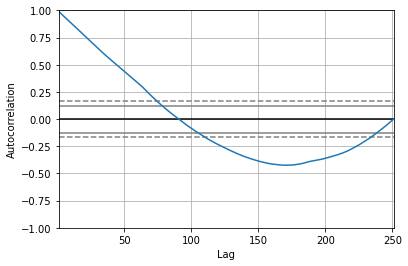

In [12]:
autocorrelation_plot(X_train) # create an autocorrelation using 0 differences

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

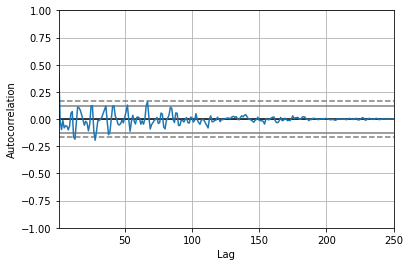

In [13]:
autocorrelation_plot(np.diff(X_train)) # creating an autocorrelation plot with 1 difference 

One difference was enough, so we set `d = 1` in $ARIMA(p,d,q)$. Now, we need to test how many memory and average terms we need. This is typically done by testing $0,1,$ or $2$ memory terms (this is $p$) and average terms (this is $q$). We verify which is the best used the Akaike Information Criteria (AIC) and Bayes Information Criteria (BIC). These are information theoretic terms that tells how "simple" this model is. The goal is to use a model of a low AIC and BIC values. 

In [14]:
# 1 diff was needed so d = 1 for ARIMA (p, d, q)
d = 1
for p in range(3): # iterate on p values
    for q in range(3): # iterate on q values 
        print('p = ', p, '| q = ', q)
        model = ARIMA(X_train, order=(p,d,q)) # create a model with these parameters
        results_ARIMA = model.fit() # train a model
        print('aic = ', results_ARIMA.aic)
        print('bic = ', results_ARIMA.bic)
        print('==================NEXT MODEL==================')


p =  0 | q =  0
aic =  510.1442284005786
bic =  513.6656893184409
==================NEXT MODEL==================
p =  0 | q =  1
aic =  418.7914146142671
bic =  425.8343364499916
==================NEXT MODEL==================
p =  0 | q =  2
aic =  401.24887440225837
bic =  411.8132571558451
==================NEXT MODEL==================
p =  1 | q =  0
aic =  403.1620563713611
bic =  410.20497820708556
==================NEXT MODEL==================
p =  1 | q =  1
aic =  401.09885445965807
bic =  411.6632372132448
==================NEXT MODEL==================
p =  1 | q =  2
aic =  373.35276526917244
bic =  387.4386089406214
==================NEXT MODEL==================
p =  2 | q =  0
aic =  402.5297096439082
bic =  413.09409239749493
==================NEXT MODEL==================
p =  2 | q =  1
aic =  402.94870425329725
bic =  417.0345479247462
==================NEXT MODEL==================
p =  2 | q =  2
aic =  373.28223461044325
bic =  390.8895391997545
==================NEXT 

In [15]:
p = 1 
q = 2
model = ARIMA(X_train, order=(p,d,q))
results_ARIMA = model.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  251
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -182.676
Date:                Thu, 23 Feb 2023   AIC                            373.353
Time:                        12:09:37   BIC                            387.439
Sample:                             0   HQIC                           379.022
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2084.913      0.000       0.999       1.001
ma.L1         -0.5340      0.128     -4.158      0.000      -0.786      -0.282
ma.L2         -0.4647      0.071     -6.571      0.0

Here, we compute the mean square error (MSE) of the $ARIMA(1,1,2)$ model on the testing data.

In [16]:
print('MSE = ', np.mean((results_ARIMA.forecast(math.floor(len(cpi) * .3)) - X_test) ** 2))

MSE =  67.81060707412108


Below, we plot the testing portion of our resulting model. 

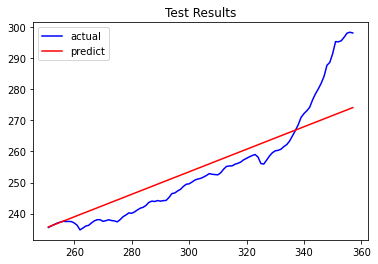

In [17]:
plt.plot(cpi[math.ceil(len(cpi) * .7):], color = 'blue', label = 'actual') 
plt.plot(results_ARIMA.forecast(math.floor(len(cpi) * .3)), color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()

Below, we plot the training results and report MSE.

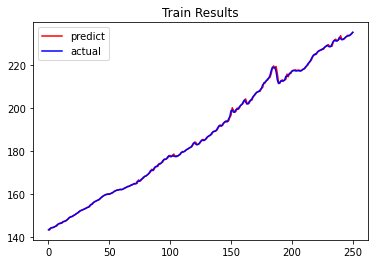

MSE =  0.2502951358455455


In [18]:
plt.plot(results_ARIMA.fittedvalues[1:], color = 'red', label = 'predict') # the first item is 0 as the time series is not infinite
plt.plot(cpi[:math.ceil(len(cpi) * .7)], color = 'blue', label = 'actual') 
plt.legend()
plt.title('Train Results')
plt.show()
print('MSE = ', np.mean((results_ARIMA.fittedvalues[1:] - X_train) ** 2))

This model was much more accurate on the training set than the testing set. The model was not able to predict extreme inflation striking to quite the level it did, and instead was predicting nearly linear growth.

## Augmenting with $GARCH(1,2)$

Necessary pip install packages for these models are here.

In [ ]:
%pip install pmdarima

In [ ]:
%pip install arch

In [ ]:
# necessary imports for garch
import pmdarima
import arch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

To create the ARIMA model, we will use the same parameters as before.

In [30]:
df = pd.read_csv('ALL_DATA_Marc93.csv') # read the dataframe 
cpi = df['CPI'] # pull only the CPI
X_train = cpi[:math.ceil(len(cpi) * .7)] # create the training set 
X_test = cpi[math.ceil(len(cpi) * .7):] # create the testing set 
arimaModel = pmdarima.ARIMA((1,1,2))
print('original test MSE = ', np.mean((X_train - arimaModel.fit(X_train).fittedvalues()[1:]) ** 2))
arimaModelResiduals = arimaModel.resid()[1:] # the difference of 1 requires this 


original test MSE =  0.23694398905919364


Now, we will train a $GARCH(1,2)$ model, as this is the same $p$ and $q$ from the ARIMA model.

In [36]:
garch = arch.arch_model(arimaModelResiduals,vol="Garch", p=1, q=2)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 4930.639000010183
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1171.5549227091951
Iteration:      3,   Func. Count:     28,   Neg. LLF: 269.69524926943853
Iteration:      4,   Func. Count:     36,   Neg. LLF: 127.05135978192988
Iteration:      5,   Func. Count:     42,   Neg. LLF: 126.8248398192984
Iteration:      6,   Func. Count:     48,   Neg. LLF: 126.8464627693876
Iteration:      7,   Func. Count:     55,   Neg. LLF: 126.81604624137032
Iteration:      8,   Func. Count:     61,   Neg. LLF: 126.81604549443503
Optimization terminated successfully    (Exit mode 0)
            Current function value: 126.81604549443503
            Iterations: 8
            Function evaluations: 61
            Gradient evaluations: 8


Now, we will predict the test results. 

In [75]:
garchResults = garch_fitted.forecast(horizon = len(X_test), reindex = False) # predict the future residuals
garchTest = garchResults.residual_variance.to_numpy()[0] 
arimaTest = arimaModel.predict(len(X_test)) # predict arima
result = arimaTest + garchTest # combine results

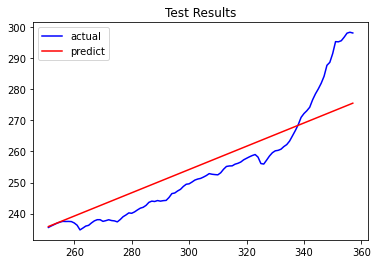

MSE =  65.56631047408236


In [76]:
plt.plot(cpi[math.ceil(len(cpi) * .7):], color = 'blue', label = 'actual') 
plt.plot(result, color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()
print('MSE = ', np.mean((X_test - result) ** 2))

We can conclude that adding extra infromation from the training residuals is not sufficient to even create a noticable change in the original $ARIMA(1,1,2)$ model. Thus, it is better to use only the original ARIMA model.

# Model 3: Multilinear Regression

Test Accuracy:  0.7452339150760441
MSE:  345.9247497311432
Coefficients:  [[45.90766982 -8.05468303 -1.179352    2.30721954]]
Intercept:  [22.06997525]


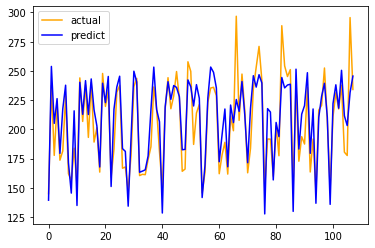

In [23]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

data = pd.read_csv("ALL_DATA_Marc93.csv", index_col=False)

# input: SPY, DGS6MO, UNRATE, G17, outcome: CPI
x = data[["SPY", "DGS6MO", "UNRATE", "G17"]].to_numpy()
y = data[["CPI"]].to_numpy()

# 70-30 train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

lin_reg = LinearRegression()  # build the linear regression model
lin_reg.fit(x_train,y_train)  # train the linear regression model

# predict outcome on test
y_pred = lin_reg.predict(x_test)

# test accuracy
test_acc = lin_reg.score(x_test, y_test)
print("Test Accuracy: ", test_acc)

# mse
mse = mean_squared_error(y_test,y_pred)
print("MSE: ", mse)

# linear regression formula
coef = lin_reg.coef_
intr = lin_reg.intercept_
print("Coefficients: ", coef)
print("Intercept: ", intr)

# visualize
plt.plot(y_test, color ='orange', label = 'actual')
plt.plot(y_pred, color ='b', label = 'predict')
plt.legend()
plt.show()

# Model 4: Neural Networks

Warning: This is best with a GPU, so run this on google colab or a GPU for best results.

# **Feedforward neural network**

This notebook will describe the process of training and testing a neural network to predict the consumer price index.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler   
from sklearn.metrics import mean_squared_error, accuracy_score

Must make sure that we are using GPU for efficient running of the following code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

torch.manual_seed(1)

Using cuda device


# Prepare the data for training

Here we load the data and split the training and test datasets. As a group, we agreed to have a 70-30 train test split for each of our models. 


In [3]:
# need to choose ALL_DATA_Marc93.csv file from computer
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('ALL_DATA_Marc93.csv')
df.head()

Saving ALL_DATA_Marc93.csv to ALL_DATA_Marc93 (3).csv


,Date,CPI,SPY,DGS6MO,UNRATE,G17
0,1-Mar-1993,143.3,0.017593,3.145652,7.0,65.0176
1,1-Apr-1993,143.8,-0.020986,3.062857,7.1,65.2041
2,1-May-1993,144.2,0.026970,3.165500,7.1,64.9433
3,1-Jun-1993,144.3,-0.003455,3.294545,7.0,65.0984
4,1-Jul-1993,144.5,0.002199,3.257619,6.9,65.2554


In [4]:
# create input + output data
X = np.array(df[['SPY','DGS6MO','UNRATE','G17']])
y = np.array(df['CPI'])

# 70 30 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Designing the neural net

Here we define the dataset and architecture of the neural network. We also define the hyperparameters for the neural network such as the epochs and learning rate. Altering these will affect the performance of the model in predicting the CPI. 

In [5]:
class CPIDataset(Dataset):
    
    def __init__(self, X_data, y_data):
      if not torch.is_tensor(X) and not torch.is_tensor(y):
        X_data = MinMaxScaler().fit_transform(X_data) # need to normalize data to (0,1) before feeding to nerural net

        # change to tensor 
        self.X_data = torch.from_numpy(X_data)
        self.y_data = torch.from_numpy(y_data)
        
    def __getitem__(self, i):
        return self.X_data[i], self.y_data[i]
        
    def __len__ (self):
        return len(self.X_data)

In [6]:
# feedforward neural  net with 3 hidden layers and ReLU activation function
class NeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super(NeuralNetwork, self).__init__()
        
        # defining neural net architecture
        self.layers = nn.Sequential(
            nn.Linear(num_features,16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)


In [24]:
# defining hyperparameters
EPOCHS = 150
BATCH_SIZE = 10
LEARNING_RATE = 1e-3
NUM_FEATURES = X_train.shape[1]

print(NUM_FEATURES)

# initialize dataset and Dataloader
train_dataset = CPIDataset(X_train, y_train)
test_dataset = CPIDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# transfer model to GPU
model = NeuralNetwork(NUM_FEATURES).to(device)
print(model)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

4
NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


# Training the neural net

In [25]:
loss_stats = []

print("Begin training.")

for e in range(0, EPOCHS):
  curr_loss = 0
  model.train()
  for input, target in train_loader:

    input, target = input.to(device), target.to(device)

    #reset gradients to 0 per mini-batch
    optimizer.zero_grad()

    output = model(input.float())
    train_loss = loss_function(output, target.float().unsqueeze(1))

    # compute the gradient and update the network parameters
    train_loss.backward()
    optimizer.step()

    curr_loss += train_loss.item()

  loss_stats.append(curr_loss/len(train_loader))#calculate average loss for each eopch
  print(f'Epoch {e+0:03}: | Train Loss: {curr_loss/len(train_loader):.5f}')

print('Training process has finished.')

Begin training.
Epoch 000: | Train Loss: 45321.88625
Epoch 001: | Train Loss: 45189.48766
Epoch 002: | Train Loss: 44913.76969
Epoch 003: | Train Loss: 44162.71203
Epoch 004: | Train Loss: 42286.03656
Epoch 005: | Train Loss: 38355.98961
Epoch 006: | Train Loss: 31420.02328
Epoch 007: | Train Loss: 21507.19105
Epoch 008: | Train Loss: 10933.49478
Epoch 009: | Train Loss: 3818.76454
Epoch 010: | Train Loss: 1717.72890
Epoch 011: | Train Loss: 1491.53751
Epoch 012: | Train Loss: 1404.30174
Epoch 013: | Train Loss: 1328.59616
Epoch 014: | Train Loss: 1260.09886
Epoch 015: | Train Loss: 1198.52856
Epoch 016: | Train Loss: 1138.13942
Epoch 017: | Train Loss: 1080.57802
Epoch 018: | Train Loss: 1032.00737
Epoch 019: | Train Loss: 983.61669
Epoch 020: | Train Loss: 936.15747
Epoch 021: | Train Loss: 894.94928
Epoch 022: | Train Loss: 857.35738
Epoch 023: | Train Loss: 822.51232
Epoch 024: | Train Loss: 790.95770
Epoch 025: | Train Loss: 766.93762
Epoch 026: | Train Loss: 730.60542
Epoch 027: 

Text(0.5, 1.0, 'Train Loss/Epoch')

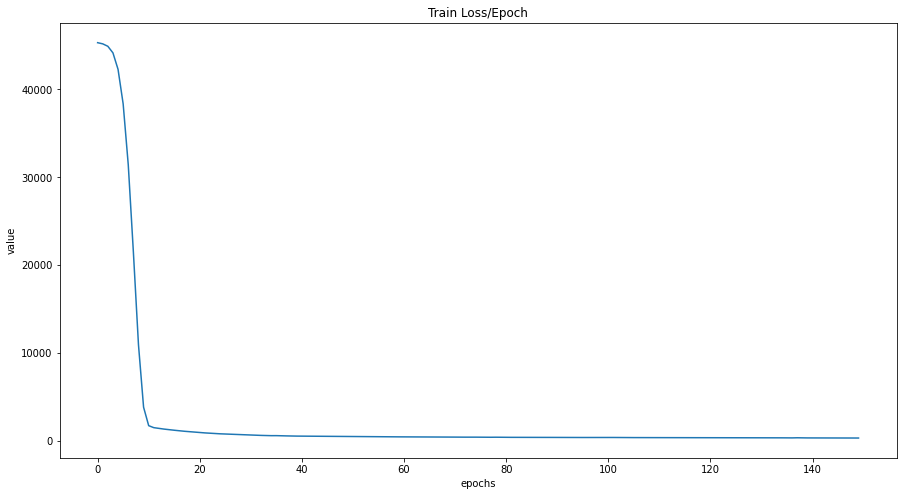

In [26]:
# plotting training loss
train_val_loss_df = pd.DataFrame(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value").set_title('Train Loss/Epoch')

# Testing the neural net

We use mean square error (MSE) as the testing accuracy metric. This will tell us how well the neural network performed in predicting the CPI. 

In [27]:
y_pred = []

# using test data to get predicted CPI values
with torch.no_grad(): #don't want to use backpropogation here
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        X_batch = X_batch.float()
        y_test_pred = model(X_batch).cpu().detach().numpy().reshape(-1)
        y_pred.append(y_test_pred)

y_pred = [a.squeeze().tolist() for a in y_pred]

In [28]:
# calculcating MSE for accuracy metric
mse = mean_squared_error(y_test, y_pred)
print("MSE =", mse)

MSE = 297.10388699733295


We also plot a comparison between the actual and predicted CPI's for a visual on the neural net's performance.

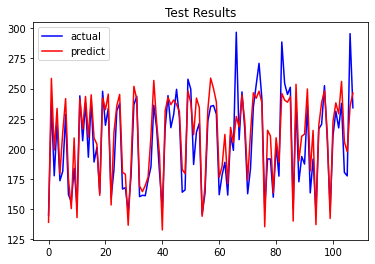

In [29]:
plt.plot(y_test, color = 'blue', label = 'actual') 
plt.plot(y_pred, color = 'red', label = 'predict') 
plt.title('Test Results')
plt.legend()
plt.show()